In [1]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import re
from torchvision.transforms import functional as F
from torchvision.ops.boxes import box_iou
import random

In [2]:
!pip install --upgrade albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e .
from ranger import Ranger  
%cd ..
#https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1
!git clone https://github.com/davda54/sam.git
%cd sam
import sam
print("Imported SAM Successfully from github .py file")
%cd ..

/content
Cloning into 'sam'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 121 (delta 51), reused 46 (delta 16), pack-reused 0
Receiving objects: 100% (121/121), 634.81 KiB | 16.28 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/sam
Imported SAM Successfully from github .py file
/content


In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## To Do: 

### Implement smart thresholding or make sure the infer code threshold differently for predicted bad spots than predicted fruits. Implement IoU thresholding. 

### Simplify code in forward function

### Find and Download a lot more data that have bad spots and healthy etc. (Look at the download instructions).  

### Implement ImageWoof Techniques into model and expeirment. Also look at papers with code (State of the art Object Detection). Look at Google's (EffecientDet)
Look at this:
https://paperswithcode.com/paper/detection-in-crowded-scenes-one-proposal

### Move some collab to another notebook file.

### Try to get albumentations/ transforms to work
https://www.kaggle.com/abhinav97dutt/faster-rcnn-training-with-augmentations
https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

Try to Understand the concept of the metrics you apply. Currently, mAP.

oppurtunity to add on albumentation pytorch metrics. Converting numpy to pytorch. 

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
###### Find and Download a lot more data that have bad spots and healthy etc. 

#### Could sort of size using .py script and analayze same images.

##### Add to the spreadsheet by getting info about agencies or research that is to help people who suffer from blindness.


## Links 
* Model: 
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
https://kaggle.com/kshitijpatil09/pytorch-mean-absolute-precision-calculation?scriptVersionId=40816383

* Metrics: 
https://manalelaidouni.github.io/manalelaidouni.github.io/Evaluating-Object-Detection-Models-Guide-to-Performance-Metrics.html#precision




# How to solve bad spots problem 
First run the fruit detector -> bouding box over every fruit. 
Then I will crop the image along the bouding box. 
Then run the cropped image through another bounding box detector and get object detection of bad_spots.

# Another solution 
Find Models that can work with neural network object detection crowding. 

#Another Solution
So I can remove the bad spot label and then have
["Apple", "Bad Apple", "Strawberry", "Bad Strawberry"] etc.

#Even another solution 
["Apple", "Specific Apple badspot"]
Like current model except differtiating against other black spots.

In [4]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Fruit Defects Dataset HalfWay.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
#For one strawberry batch please drop watermark rows
np.random.seed(42)
torch.manual_seed(42)
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)
rottenStrawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberriesBatch1Labels.csv", header = None)
rottenStrawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch2RottenStrawBerryLabels/RottenStrawBerryBatch2.csv", header = None)
rottenStrawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/rottenStrawberryBtch3labels.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, 
                          rottenApple_csv_batch_2, rottenApple_csv_batch_3, rottenStrawberry_csv_batch_1, rottenStrawberry_csv_batch_2, 
                          rottenStrawberry_csv_batch_3]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))
def run_dataframe_check():
  assert total_row_sum_check == fruit_df.shape[0]
  print("DataFrame shape: {}".format(fruit_df.shape))
  print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
  print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))

run_dataframe_check()

Checked total rows from all the dataframes combined: 844
DataFrame shape: (844, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots']
Number of Unique Images 246


In [6]:
#Specify more image types when 
def more_specific_Image_id(image_id, fruit):
  if fruit == "Bad_Spots":
    if re.search("RottenStrawberries", image_id):
      return "Strawberry_Bad_Spot"
    elif re.search("RottenApples", image_id):
      return "Apple_Bad_Spot"
    else:
      raise ValueError("Could not find a match for some of the Image_ids")

  else:
    return fruit

fruit_df["Fruit"] = fruit_df.apply(lambda row: more_specific_Image_id(row.Image_id, row.Fruit), axis = 1)

run_dataframe_check()

DataFrame shape: (844, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Apple_Bad_Spot' 'Strawberry_Bad_Spot']
Number of Unique Images 246


In [7]:
#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

In [8]:
bounding_box_dict = dict()
labels_dict = dict()
classes = ["Placeholder", "Apples", "Strawberry", "Apple_Bad_Spot", "Strawberry_Bad_Spot"]
# classes = ["Apples", "Strawberry", "Apple_Bad_Spot", "Strawberry_Bad_Spot"]
# classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

245
245


## Class function + util functions

In [9]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(
        (pair_of_coord[2] - pair_of_coord[0]) * (pair_of_coord[3] - pair_of_coord[1])
    )
  return torch.tensor(area_of_each_bb, dtype=torch.int32)

def convert_min_max(bb_coord):
  for pair_of_coord in bb_coord:
    pair_of_coord[2], pair_of_coord[3] = (pair_of_coord[0] + pair_of_coord[-2]), (pair_of_coord[1] + pair_of_coord[-1])
  return bb_coord

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms, mode):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())

    np.random.shuffle(self.imgs_key)
    if (mode == "train"):
      self.imgs_key = self.imgs_key[:int(len(self.imgs_key) * 0.8)]
    else:
      self.imgs_key = self.imgs_key[int(len(self.imgs_key) * 0.8):]

    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths) 
    img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    boxes = convert_min_max(torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32))
    
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }

      sample = self.transforms(**sample)
      img = sample['image']
      target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

In [10]:
# Albumentations
def get_transforms(mode):
  if (mode == "train"):
    return A.Compose([
                      A.Cutout(),
                      A.HorizontalFlip(),
                      A.VerticalFlip(), 
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "test"):
    return A.Compose([
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  else:
    raise ValueError("mode is wrong value can either be train or test")

In [16]:
#Using this stack overflow (https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)
#(Suppose for example, you want to create batches of a list of varying dimension tensors. The below code pads sequences with 0 until the maximum sequence size of the batch,)
#Collate_fn is a function that is used to process your batches before you pass it to dataloader. In my case since I have different sized images I need a way to stack batches b/c torch.stack won't work.
#So I use zip which can accept tensors of different lengths and make them stacked with the size of the lowest length list given. Therefore stacking all the images in a batch 
#Successfully unlike torch.stack and doing that processing to every batch makes collate_fn vital since I have different image sizes.

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

train_batch_size = 2
test_batch_size = 2

train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "train"), mode = "train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= collate_fn)

test_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "test"), mode = "test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True, collate_fn= collate_fn)


In [12]:
# COLORS = [(255, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0)]
COLORS = [(0, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0), (255, 0, 0)]

def draw_boxes(boxes, labels, image, infer = False):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    if infer:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

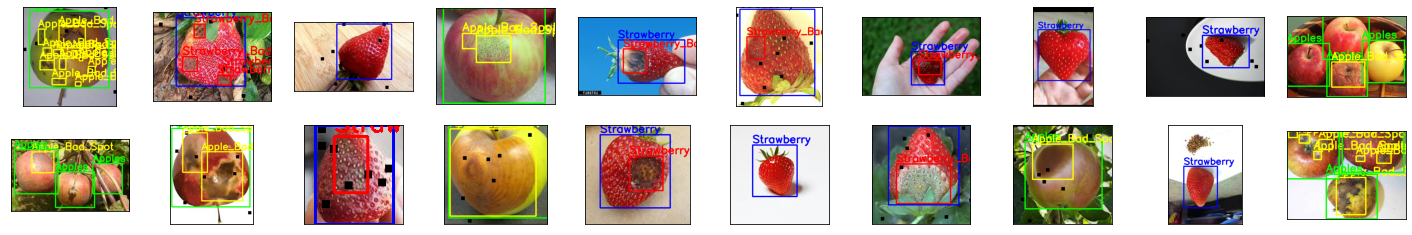

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx])
    plt.imshow(image)

## What we learned
is that the model outputs losses when in train mode 
when in model.eval model, the model code then return only a prediction with no losses.

In [17]:
def calculate_metrics(target_box,predictions_box,scores, device):

    #Get most confident boxes first and least confident last
    predictions_box = predictions_box[scores.argsort().flip(-1)]
    iou_mat = box_iou(target_box,predictions_box)
    #return a one by one matrix that is form (target_box, prediction_box) or (1, 1)
    target_boxes_count, prediction_boxes_count = iou_mat.shape
    
    mAP_Matrix = torch.zeros_like(iou_mat)
    # if not matrix coordinates that relate to nothing.
    if not iou_mat[:,0].eq(0.).all():
      index_of_biggest_iou = iou_mat[:,0].argsort()[-1]
      mAP_Matrix[index_of_biggest_iou,0] = 1

    for pr_idx in range(1,prediction_boxes_count):
        not_assigned = torch.logical_not(mAP_Matrix[:,:pr_idx].sum(1)).long()
        targets = not_assigned * iou_mat[:,pr_idx]

        if targets.eq(0).all():
            continue

        pivot = targets.argsort()[-1]
        mAP_Matrix[pivot,pr_idx] = 1

    # mAP calculation
    tp = mAP_Matrix.sum()
    fp = mAP_Matrix.sum(0).eq(0).sum()
    fn = mAP_Matrix.sum(1).eq(0).sum()

    mAP = tp / (tp+fp)
    mAR = tp / (tp+fn)

    return mAP, mAR

def run_metrics_for_batch(output, targets, mAP, mAR, missed_images, device):
  for pos_in_batch, image_pred in enumerate(output):
    assert (len(image_pred["boxes"]) == len(image_pred["labels"]) == len(image_pred["scores"]))
    if len(image_pred["boxes"]) != 0:
      curr_mAP, curr_mAR = calculate_metrics(targets[pos_in_batch]["boxes"], output[pos_in_batch]["boxes"], output[pos_in_batch]["scores"], device)
      mAP, mAR = mAP + curr_mAP , mAR + curr_mAR
    else:
      missed_images += 1 
  
  return mAP, mAR, missed_images

In [18]:
def train(net, epochs, train_loader, test_loader, lr, weight_decay, 
          print_every = 6, lo_test_dataset = len(test_dataset), lo_train_dataset = len(train_dataset)):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Check which parameters can calulate gradients. 
    params = [p for p in net.parameters() if p.requires_grad]
    # optimizer = optim.Adam(params, lr = lr, weight_decay = weight_decay)
    base_optimizer = Ranger
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr = lr, weight_decay = weight_decay)

    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = steps = train_mAP = train_mAR = missed_train_images = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            net.train()

            steps += 1

            images = [image.to(device) for image in images]
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            optimizer.zero_grad()
            
            loss_dict = net(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            net.eval()
            train_mAP, train_mAR, missed_train_images = run_metrics_for_batch(net(images), targets, train_mAP, train_mAR, missed_train_images, device)
            net.train()

            losses.backward()
            optimizer.first_step(zero_grad = True)

            loss_dict = net(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.second_step(zero_grad = True)

            train_loss +=  losses.item()

            if (steps % print_every) == 0:

              with torch.no_grad():
                test_mAP = test_mAR = missed_test_images = test_loss = 0

                for images, targets in test_loader:

                  net.eval()
                  if device == torch.device("cuda"):
                    images = [image.to(device) for image in images]
                    targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

                  output = net(images)
                  test_mAP, test_mAR, missed_test_images = run_metrics_for_batch(output, targets, test_mAP, test_mAR, missed_test_images, device)

                  net.train()
                  test_loss_dict = net(images, targets)
                  test_losses = sum(loss for loss in test_loss_dict.values())

                print("Epoch {}/{} | Batch Number: {} | Train_loss: {:0.2f} | Test_loss: {:0.2f} | Test mAP: {:0.2f}% | Test mAR: {:0.2f}% | Missed Test Images: {}".format(
                    epoch + 1, epochs, steps, train_loss, (test_losses / float(lo_test_dataset)) * 100.,  
                    (test_mAP / float(lo_test_dataset)) * 100., (test_mAR / float(lo_test_dataset)) * 100.,missed_test_images))
                
              assert (steps % print_every) == 0
              train_loss = 0
                 
        print("\n Epoch {} Final Train mAP: {:0.2f}% | Epoch {} Final Train mAR: {:0.2f}% | Epoch {} Final Missed Train Images: {} out of {} images \n".format(
            epoch + 1, (train_mAP / float(lo_train_dataset)) * 100., 
            epoch + 1, (train_mAR / float(lo_train_dataset)) * 100., 
            epoch + 1, missed_train_images, lo_train_dataset
        ))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))
    return net


## This link shows the problem https://github.com/pytorch/vision/issues/2740
The answer from @oke-aditya is correct. You are probably passing to the model bounding boxes in the format [xmin, ymin, width, height], while Faster R-CNN expects boxes to be in [xmin, ymin, xmax, ymax] format.

Changing this should fix the issue.

We have btw recently added box conversion utilities to torchvision (thanks to @oke-aditya ), they can be found in

Look at box convert or doing it locally also works.

### https://github.com/pytorch/vision/blob/a98e17e50146529cdfadb590ba063e6bbee71de2/torchvision/ops/boxes.py#L137-L156




In [21]:
import torchvision
backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
backbone.roi_heads.box_predictor.cls_score.out_features = 4
backbone.roi_heads.box_predictor.bbox_pred.out_features = 16
# backbone.roi_heads.box_predictor.cls_score.out_features = 3
# backbone.roi_heads.box_predictor.bbox_pred.out_features = 12


In [22]:
another_one = train(backbone, 27, train_loader, test_loader, 0.0005, weight_decay = 1e-4, print_every = 12)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    k: 6
    lr: 0.0005
    rho: 0.05
    step_counter: 0
    weight_decay: 0.0001
)
Epoch 1/27 | Batch Number: 12 | Train_loss: 42.30 | Test_loss: 1.66 | Test mAP: 39.83% | Test mAR: 90.82% | Missed Test Images: 0
Epoch 1/27 | Batch Number: 24 | Train_loss: 36.52 | Test_loss: 3.21 | Test mAP: 39.60% | Test mAR: 93.95% | Missed Test Images: 0
Epoch 1/27 | Batch Number: 36 | Train_loss: 23.33 | Test_loss: 1.31 | Test mAP: 43.27% | Test mAR: 90.44% | Missed Test Images: 0
Epoch 1/27 | Batch Number: 48 | Train_loss: 14.58 | Test_loss: 1.52 | Test mAP: 52.98% | Test mAR: 92.06% | Missed Test Images: 0
Epoch 1/27 | Batch Number: 60 | Train_loss: 11.21 | Test_loss: 1.21 | Test mAP: 44.88% | Test mAR: 90.54% | Missed Test Images: 0
Epoch 1/27 | Batch Number: 72 | Train

In [39]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48
def intersect(box_a, box_b):

    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def jaccard_iou(box_a, box_b):

    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

In [49]:
jaccard_iou(torch.tensor([[0, 0, 100, 100]]), torch.tensor([[200, 200, 300, 300], [0, 0, 19, 9], [0, 0, 100, 100]]))

tensor([[0.0000, 0.0171, 1.0000]])

In [103]:
def infer_image(image_file_path, trained_model, distance_thresh, iou_thresh, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # print("Current device: {}".format(device))

  #Just load it up as PIL. Avoid using cv2 because do not need albumentations
  torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
  trained_model.to(device)
  trained_model.eval()
  # print("Image Size: {}".format(torch_image.size()))

  start_time = time.time()
  results = trained_model(torch_image)
  end_time = time.time() - start_time

  # print(results)
  # print("Time of Inference {:0.2f}".format(end_time))

  valid_box_count = 0
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break
    else:
      valid_box_count += 1

  if valid_box_count == len(results[0]["scores"]):
    low_index_start = len(results[0]["scores"])
  

  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]
  
  #build bad_spot watch index Will need updating if I add more classes
  bad_spot_index = [ii for ii, label in enumerate(results[0]["labels"]) if label == 3 or label == 4]
  # fruit_index = [ii for ii, _ in enumerate(results[0]["labels"]) if ii not in bad_spot_index]

 
  # print(results[0]["boxes"][[bad_spot_index]])

  # #Go through every single box and do ioU with other boxes of same label (bad spot or fruit). 
  i = 0 
  for current_index, _ in enumerate(results[0]["boxes"]):
    if current_index in bad_spot_index:
      # current_index_iou = jaccard_iou(results[0]["boxes"][current_index].view(1, -1).to(device), 
      #                                 torch.tensor(
      #                                     [box.tolist() for ii, box in enumerate(results[0]["boxes"][[bad_spot_index]]) if ii != (bad_spot_index.index(current_index))]).to(device))

      current_index_iou = jaccard_iou(results[0]["boxes"][current_index].view(1, -1).to(device),
                                      results[0]["boxes"][[bad_spot_index]].to(device))
      for index, iou in current_index_iou:
        if iou > iou_thresh:
          for key in results[0]:
            results[0][key] = torch.cat((results[0][key][:other_box, :], results[0][key][(other_box + 1):, :]), axis = 0)
  #         bad_spot_index.pop(other_box)









                                      
      # other_bad_spot_indices =
      # jaccard_iou(results[0]["boxes"][current_index], )
  #     for other_box in bad_spot_index:
  #       if current_box == other_box:
  #         continue
  #       current_iou = jaccard_iou(results[0]["boxes"][current_box], results[0]["boxes"][other_box])
  #       if current_iou > iou_thresh:
  #         #Remove the other box from index list and results (removing other box altogether). 
  #         for key in results[0]:
  #           results[0][key] = torch.cat((results[0][key][:other_box, :], results[0][key][(other_box + 1):, :]), axis = 0)
  #         bad_spot_index.pop(other_box)

  #   else:

  #     for other_box in fruit_index:
  #       if current_box == other_box:
  #         continue
  #       current_iou = jaccard_iou(results[0]["boxes"][current_box], results[0]["boxes"][other_box])
  #       if current_iou > iou_thresh:
  #         #Remove the other box from index list and results (removing other box altogether). 
  #         for key in results[0]:
  #           results[0][key] = torch.cat((results[0][key][:other_box, :], results[0][key][(other_box + 1):, :]), axis = 0)
  #         fruit_index.pop(other_box)

  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    plt.imshow(cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze(), infer = True), cv2.COLOR_BGR2RGB))
  
  return results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1.0000, 0.4543, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([[0.4543, 1.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([[0.0000, 0.0000, 1.0000, 0.2843]], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([[0.0000, 0.0000, 0.2843, 1.0000]], device='cuda:0',
       grad_fn=<DivBackward0>)


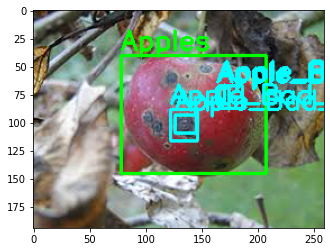

In [104]:
second_results = infer_image("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApples118.jpeg", 
            another_one, 0.4, 0.8)
# print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 865, 1300])
[{'boxes': tensor([[221.4169, 119.4188, 938.3961, 778.3038],
        [248.7849, 261.4456, 725.8231, 759.2322],
        [719.2116, 225.1184, 777.0477, 254.7273],
        [682.2741, 223.7982, 787.4518, 258.7467]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 3, 3, 3], device='cuda:0'), 'scores': tensor([0.9990, 0.9777, 0.0604, 0.0581], device='cuda:0',
       grad_fn=<IndexBackward>)}]
Time of Inference 0.02
[{'boxes': tensor([[221.4169, 119.4188, 938.3961, 778.3038],
        [248.7849, 261.4456, 725.8231, 759.2322]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1, 3], device='cuda:0'), 'scores': tensor([0.9990, 0.9777], device='cuda:0', grad_fn=<SliceBackward>)}]


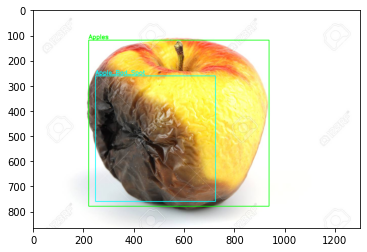

In [28]:
second_results = infer_image("/content/another_rot_app.jpg", 
            another_one, 0.6, 0)
print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 1390, 957])
[{'boxes': tensor([[ 235.5506,  403.8927,  738.6976, 1121.8507],
        [ 462.9427,  761.2334,  603.4017,  906.5168],
        [ 265.9332,  476.0062,  440.5555,  649.7932],
        [ 207.7087,  155.8962,  564.7505,  389.8158],
        [ 550.2988,  531.9961,  636.3469,  597.0240],
        [ 235.2677,  175.5485,  537.8005,  366.6303],
        [ 337.3452,  699.8942,  412.1640,  805.4291],
        [ 327.0925,  734.3229,  394.9165,  799.5851],
        [ 561.5929,  624.0842,  619.8474,  709.7795],
        [ 234.7645,  170.2711,  535.2804,  372.1566],
        [ 331.2242,  745.7145,  425.3923,  834.8360],
        [ 580.0098,  628.4484,  645.7313,  694.2408],
        [ 346.4417,  727.7999,  432.8701,  798.2244],
        [ 274.6584,  455.1642,  613.5095, 1022.7137],
        [ 299.2596,  583.9769,  388.0968,  675.4074],
        [ 526.7735,  504.7462,  661.6250,  624.9802],
        [ 354.7542,  694.2728,  429.9909,  782.1044]], device=

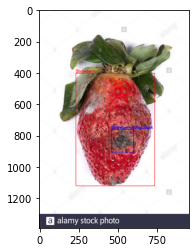

In [31]:
second_results = infer_image("/content/another.jpg", 
            another_one, 0.4, 0)
print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 975, 1300])
[{'boxes': tensor([[338.8555, 154.3964, 875.0103, 873.5104],
        [458.3870, 291.9101, 671.2951, 497.1021],
        [380.6540, 249.5839, 776.0352, 851.4078],
        [390.0089, 579.3339, 678.5972, 797.0998]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 4, 4, 4], device='cuda:0'), 'scores': tensor([0.9850, 0.3301, 0.1860, 0.1534], device='cuda:0',
       grad_fn=<IndexBackward>)}]
Time of Inference 0.02
[{'boxes': tensor([[338.8555, 154.3964, 875.0103, 873.5104]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9850], device='cuda:0', grad_fn=<SliceBackward>)}]


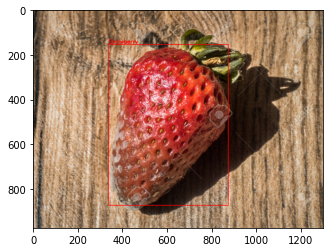

In [32]:
second_results = infer_image("/content/147181851-rotten-strawberry-on-wood-background.jpg", 
            another_one, 0.4, 0)
print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 1274, 1300])
[{'boxes': tensor([[ 158.5684,  190.1630, 1052.9418,  986.7850],
        [ 245.5050,  424.8194,  490.4470,  688.9180],
        [ 477.8534,  286.1551,  782.8240,  438.9824],
        [ 677.2304,  311.0681,  756.4943,  412.6314],
        [ 690.6259,  318.3981,  791.4131,  423.5156],
        [ 657.6609,  332.8555,  730.3028,  406.5201],
        [ 617.3628,  269.2770,  813.3844,  471.7635],
        [ 575.0919,  308.8096,  678.8339,  402.6385],
        [ 709.5002,  281.7869,  781.6508,  391.0154],
        [ 554.5856,  318.8717,  701.7249,  430.1274],
        [ 685.7160,  264.3786,  798.1007,  348.2275],
        [ 600.5219,  383.1259,  844.4426,  635.2329],
        [ 230.8821,  356.6945,  794.5837,  770.8746],
        [ 445.6846,  292.5223,  664.8111,  423.7909],
        [ 489.3306,  295.6134,  595.6146,  383.6706],
        [ 580.9627,  276.0916,  689.1736,  333.1017],
        [ 488.9444,  319.0857,  613.4016,  409.5722],
       

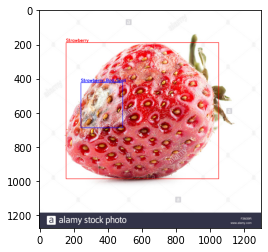

In [33]:
second_results = infer_image("/content/1starw.jpg", 
            another_one, 0.4, 0)
print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 454, 379])
[{'boxes': tensor([[ 22.4579,  71.8970, 343.5308, 424.6460],
        [185.4650, 106.0667, 333.8842, 290.9572],
        [ 74.9308, 125.0910, 328.6821, 385.3492],
        [ 80.0647,  92.0707, 162.7251, 135.4353],
        [ 17.9725,  79.4630, 337.6868, 419.4028],
        [116.6627, 281.1342, 258.1978, 345.2222],
        [ 43.9131, 155.5624, 121.3100, 237.0939],
        [136.1726, 169.9773, 178.2807, 204.9722],
        [193.8082, 145.3584, 273.4965, 267.1662],
        [139.2377, 150.2679, 176.4910, 217.8233]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 4, 4, 4, 1, 4, 4, 4, 4, 4], device='cuda:0'), 'scores': tensor([0.9801, 0.4950, 0.3255, 0.2624, 0.2358, 0.1661, 0.1266, 0.0990, 0.0814,
        0.0739], device='cuda:0', grad_fn=<IndexBackward>)}]
Time of Inference 0.02
[{'boxes': tensor([[ 22.4579,  71.8970, 343.5308, 424.6460],
        [185.4650, 106.0667, 333.8842, 290.9572]], device='cuda:0',
      

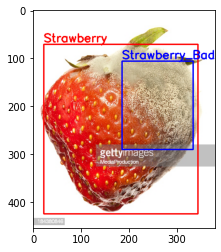

In [34]:
second_results = infer_image("/content/gettyimages-184380846-170667a.jpg", 
            another_one, 0.4, 0)
print(second_results)